# Preamble

importing

In [3]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_blobs


In [4]:
from math import floor, ceil

def adjust_bounds(xmin, xmax, ymin, ymax):
    xmin, ymin = floor(xmin), floor(ymin)
    xmax, ymax = ceil(xmax + .1*abs(xmax)), ceil(ymax + .1*abs(ymax))
    return xmin, xmax, ymin, ymax


In [5]:
def plot_linear_svc_boundaries(svm_clf, xmin, xmax, ymin = -np.inf, ymax=np.inf, support_vectors = True):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    xmin, xmax, ymin, ymax = adjust_bounds(xmin, xmax, ymin, ymax)
    xmin, xmax, ymin, ymax = xmin + .1, xmax - .1, ymin + .1, ymax - .1 # Stop plot from painting outside the lines

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    margin = 1/w[1]

    def decision_boundary(x):
        return -w[0] / w[1] * x - b / w[1]
    
    def gutter_up(x):
        return decision_boundary(x) + margin
    
    def gutter_down(x):
        return decision_boundary(x) - margin
    
    def limit(xs, f):
        return np.array([x for x in xs if f(x) > ymin and f(x) < ymax])

    x_decision = limit(x0, decision_boundary)
    x_up = limit(x0, gutter_up)
    x_down = limit(x0, gutter_down)
    svs = svm_clf.support_vectors_

    plt.plot(x_decision, decision_boundary(x_decision), "k-", linewidth=2)
    plt.plot(x_up, gutter_up(x_up), "k--", linewidth=2)
    plt.plot(x_down, gutter_down(x_down), "k--", linewidth=2)
    if support_vectors: plt.plot(svs[:, 0], svs[:, 1], 'Xr')

In [6]:
def plot_probabilities(classifier, X, y, cmap, levels = 10):
    xs, ys =  X[:, 0], X[:, 1]
    xmin, xmax, ymin, ymax = adjust_bounds(xs.min(), xs.max(), ys.min(), ys.max())
    xx, yy = np.meshgrid(np.arange(xmin, xmax, .1), np.arange(ymin, ymax, .1))
    Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    plt.contourf(xx, yy, Z.reshape(xx.shape), cmap = 'viridis', levels = levels)
    plt.colorbar()
    plt.scatter(xs, ys, c=y, cmap=cmap)


Making test data

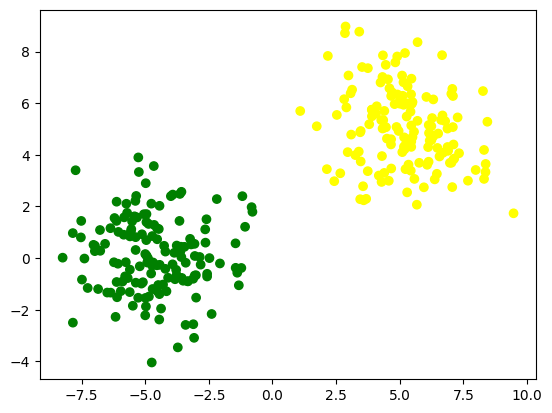

In [7]:
centers_full=[[-5, 0], [5, 5], [5, -5]]
colors_full = ["green", "yellow", "magenta"]
blobs = make_blobs(centers=centers_full[:2], cluster_std= 1.5, n_samples=300, random_state=504)

X, y = blobs

colors = ListedColormap(colors_full[:2])

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=504)


# Fitting Support Vector Machines

Creating and fitting on the training data.

In [9]:
from sklearn.svm import SVC

svm_class = SVC(probability=True, kernel='linear', random_state=504)
svm_class.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=504)

The position in the center is predicted to be green...

In [10]:
svm_class.predict([[0, 2.5]])

array([0])

... but only with 57.9% certainty. (**Note**: predict_proba isn't 100% accurate for support vector machines)

In [11]:
svm_class.predict_proba([[0, 2.5]])


array([[0.5790434, 0.4209566]])

In [12]:
svm_class.score(X_train, y_train), svm_class.score(X_test, y_test)

(1.0, 1.0)

This plot shows the areas of uncertainty. Note, that most of the points are in either the 1.0 or the 0.0 area.

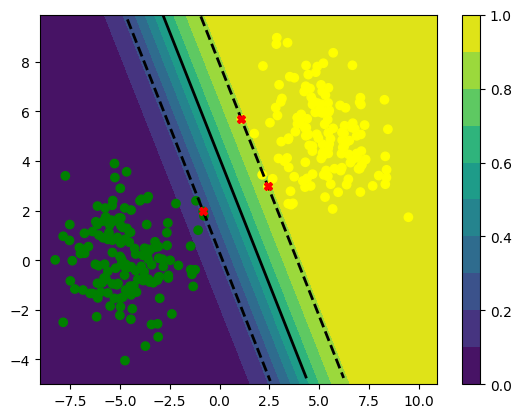

In [13]:
plot_probabilities(svm_class, X, y, colors)
plot_linear_svc_boundaries(svm_class, X[:, 0].min(), X[:, 0].max(), ymin=X[:, 1].min(), ymax=X[:, 1].max())

# With overlap

Let's see how this works in a noisier example with more overlap between the categories

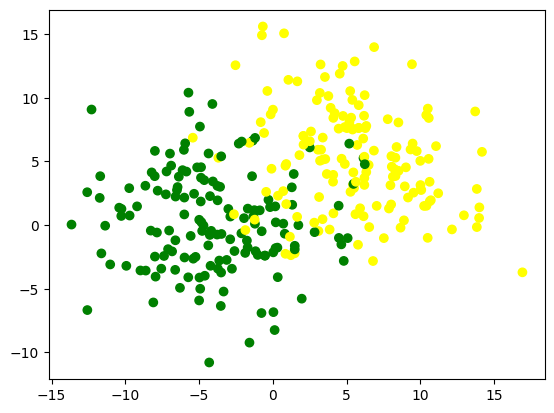

In [14]:
blobs = make_blobs(centers=centers_full[:2], cluster_std= 4, n_samples=300, random_state=504)

X, y = blobs
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=504)

colors = ListedColormap(colors_full[:2])

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors)

In [15]:
svm_class = SVC(probability=True, C=1000, kernel='linear', random_state=504)
svm_class.fit(X_train, y_train)

svm_class.score(X_train, y_train), svm_class.score(X_test, y_test)

(0.9022222222222223, 0.9066666666666666)

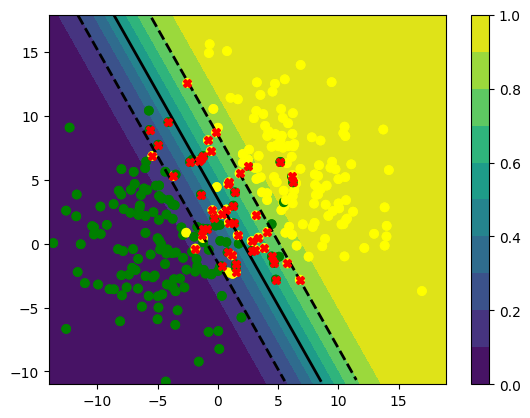

In [16]:
plot_probabilities(svm_class, X, y, colors)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors)
plot_linear_svc_boundaries(svm_class, X[:, 0].min(), X[:, 0].max(), ymin=X[:, 1].min(), ymax=X[:, 1].max(), support_vectors=True)


# Mutiple categories



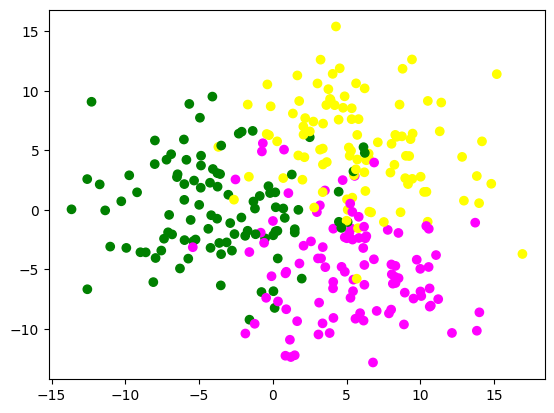

In [17]:
blobs = make_blobs(centers=centers_full, cluster_std= 4, n_samples=300, random_state=504)

X, y = blobs
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

colors = ListedColormap(colors_full)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors)

In [18]:
svm_class = SVC(probability=True, decision_function_shape='ovo', kernel='linear', random_state=504)
svm_class.fit(X_train, y_train)

svm_class.score(X_train, y_train), svm_class.score(X_test, y_test)

(0.8577777777777778, 0.8133333333333334)

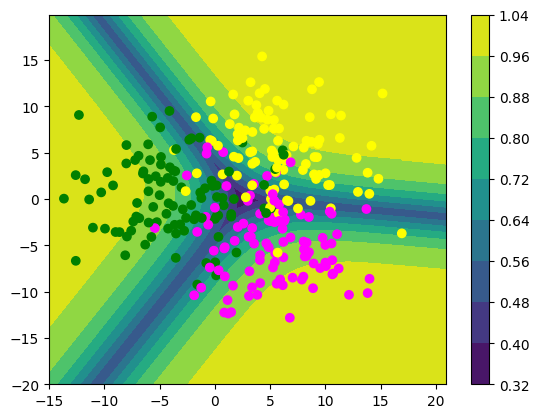

In [19]:
xx, yy = np.meshgrid(np.arange(-15, 21, .1), np.arange(-20, 20, .1))
Z = np.array([max(p) for p in svm_class.predict_proba(np.c_[xx.ravel(), yy.ravel()])])
plt.contourf(xx, yy, Z.reshape(xx.shape), cmap = 'viridis', levels = 10)
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors)

# Non-linear data

First we'll try this with the linear kernel. That shouldn't be so good.

Same datasets as for logistic regression.

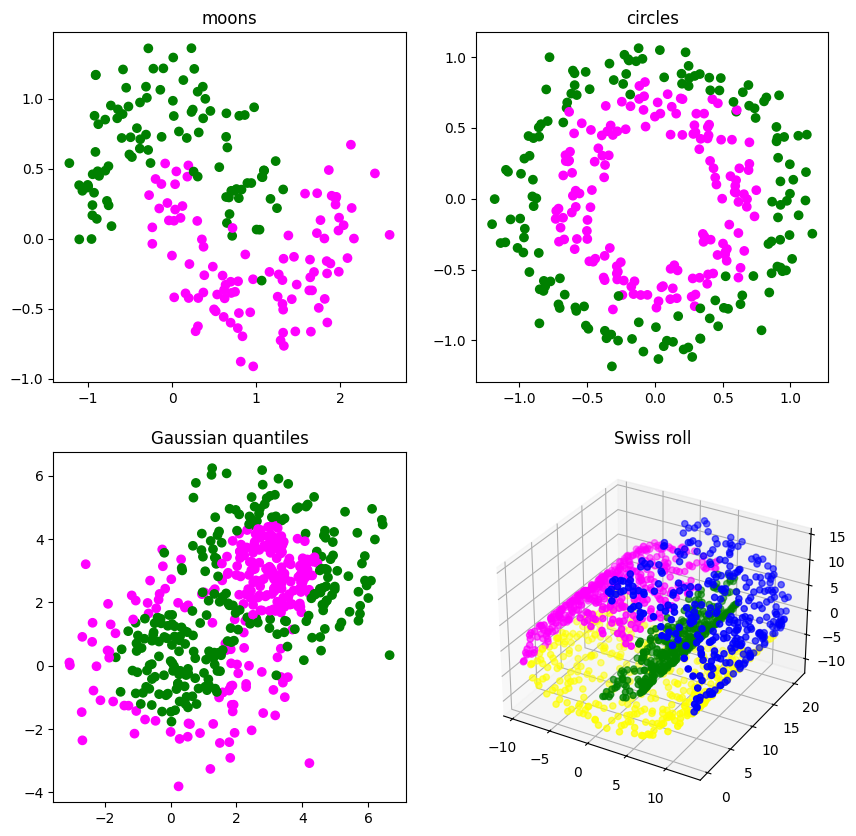

In [20]:
from sklearn.datasets import make_moons, make_circles, make_gaussian_quantiles, make_swiss_roll
from math import floor, ceil
import mpl_toolkits.mplot3d.axes3d as p3

colors = ListedColormap(['green', 'magenta', 'yellow', 'blue'])

X_moons, y_moons = make_moons(n_samples=200, noise = .2, random_state = 504)
X_circles, y_circles = make_circles(n_samples=300, factor=.65, noise = .1)
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=504)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=504)
X_quan = np.concatenate((X1, X2))
y_quan = np.concatenate((y1, - y2 + 1))

X_swiss, y_swiss = make_swiss_roll(n_samples = 1500, noise = 0.05, random_state=504)

y_min = y_swiss.min()
y_max = y_swiss.max()
y_scale = ceil(y_max - y_min)

y_swiss = np.array([floor(4 * (y - y_min) / y_scale) for y in y_swiss])

figure = plt.figure(figsize=(10, 10))

ax = figure.add_subplot(2, 2, 1, title='moons')
ax.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap=ListedColormap(['green', 'magenta']))

ax = figure.add_subplot(2, 2, 2, title='circles')
ax.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap=ListedColormap(['green', 'magenta']))

ax = figure.add_subplot(2, 2, 3, title='Gaussian quantiles')
ax.scatter(X_quan[:, 0], X_quan[:, 1], c=y_quan, cmap=ListedColormap(['green', 'magenta']))

ax = figure.add_subplot(2, 2, 4, title='Swiss roll', projection='3d')
ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=y_swiss, cmap=colors)


### Moons

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, random_state=504)
svm_class = SVC(probability=True, kernel='linear', random_state=504)
svm_class.fit(X_train, y_train)

svm_class.score(X_train, y_train), svm_class.score(X_test, y_test)

(0.8333333333333334, 0.84)

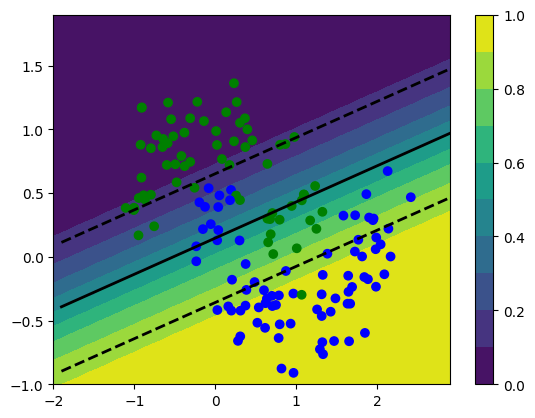

In [22]:
plot_probabilities(svm_class, X_train, y_train, colors)
plot_linear_svc_boundaries(svm_class, X_train[:, 0].min(), X_train[:, 0].max(), ymin=X_train[:, 1].min(), ymax=X_train[:, 1].max(), support_vectors=False)


We can see what it tried to do, at least. The next two are beyond fixing.

### Circles

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_circles, y_circles, random_state=504)
svm_class = SVC(probability=True, decision_function_shape='ovr', kernel='linear', random_state=504)
svm_class.fit(X_train, y_train)

svm_class.score(X_train, y_train), svm_class.score(X_test, y_test)

(0.5333333333333333, 0.4666666666666667)

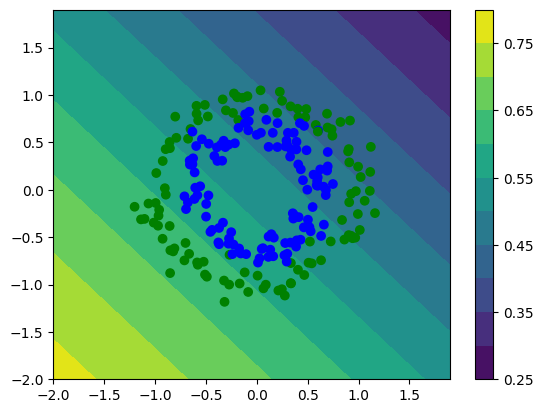

In [24]:
plot_probabilities(svm_class, X_train, y_train, colors)

### Gaussian quantiles

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_quan, y_quan, random_state=504)
svm_class = SVC(probability=True, decision_function_shape='ovr', kernel='linear', random_state=504)
svm_class.fit(X_train, y_train)

svm_class.score(X_train, y_train), svm_class.score(X_test, y_test)

(0.672, 0.6)

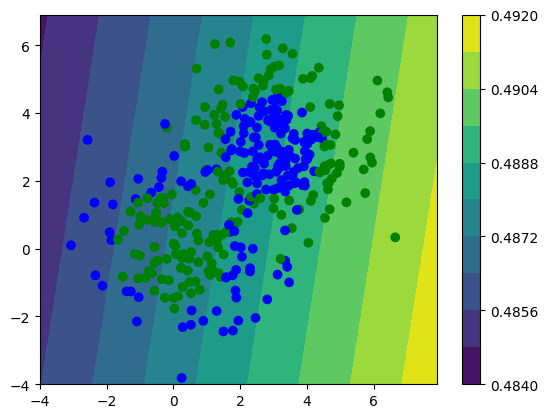

In [26]:
plot_probabilities(svm_class, X_train, y_train, colors)

### Swiss roll

Like before, this is linearly seperable.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_swiss, y_swiss, random_state=504)
svm_class = SVC(probability=True, decision_function_shape='ovr', kernel='linear', random_state=504)
svm_class.fit(X_train, y_train)

svm_class.score(X_train, y_train), svm_class.score(X_test, y_test)

(0.9564444444444444, 0.976)

# Kernels

## RBF

This is the default, and most used kernel. It is more time-consuming than the other ones, but it is more flexible and therefore tends to be most accurate.

First, let's just see how non-linear kernels work on a linear problem.

In [58]:
blobs = make_blobs(centers=centers_full, cluster_std= 4, n_samples=300, random_state=504)

X, y = blobs
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

svm_class = SVC(probability=True, decision_function_shape='ovr', gamma=1, C = 10, kernel='rbf', random_state=504)
svm_class.fit(X_train, y_train)

svm_class.score(X_train, y_train), svm_class.score(X_test, y_test)

(0.9866666666666667, 0.76)

It's about the same, but it looks very different.

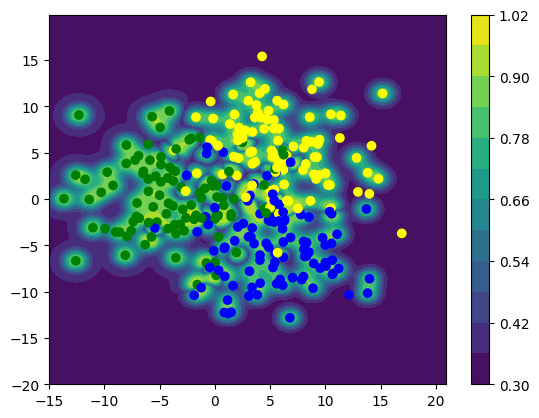

In [69]:
xx, yy = np.meshgrid(np.arange(-15, 21, .1), np.arange(-20, 20, .1))
proba = svm_class.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = np.max(svm_class.predict_proba(np.c_[xx.ravel(), yy.ravel()]), axis = 1)
plt.contourf(xx, yy, Z.reshape(xx.shape), cmap = 'viridis', levels = 10)
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors)

Try playing with gamma and C, to see what you can find.

### Moons

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, random_state=504)
svm_class = SVC(probability=True, decision_function_shape='ovr', kernel='rbf', random_state=504)
svm_class.fit(X_train, y_train)

svm_class.score(X_train, y_train), svm_class.score(X_test, y_test)

(0.9666666666666667, 0.98)

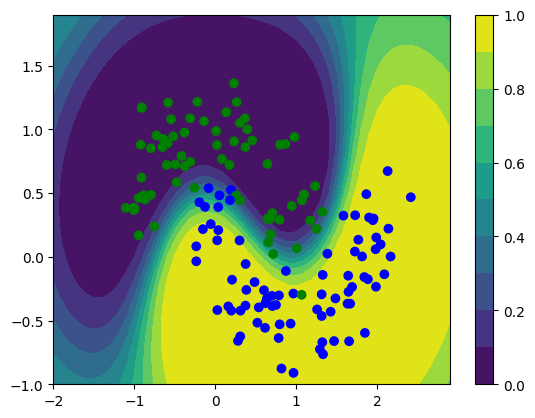

In [31]:
plot_probabilities(svm_class, X_train, y_train, colors)

This is already quite good with the default hyperparameters, but try it with gamma = 10 or C = 10.

### Circles

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_circles, y_circles, random_state=504)
svm_class = SVC(probability=True, decision_function_shape='ovr', kernel='rbf', random_state=504)
svm_class.fit(X_train, y_train)

svm_class.score(X_train, y_train), svm_class.score(X_test, y_test)

(0.96, 0.96)

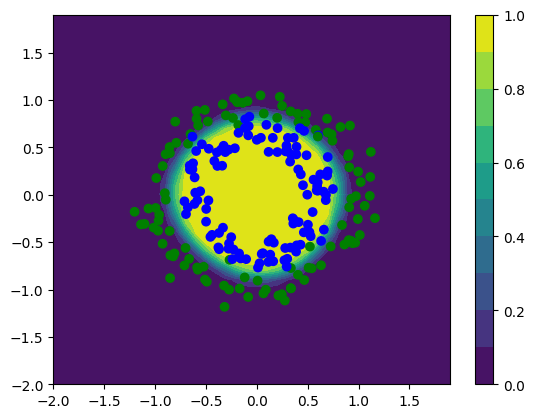

In [33]:
plot_probabilities(svm_class, X_train, y_train, colors)

With boundaries this close, this is very dependent on gamma. Try it out.

### Gaussian Quantiles

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_quan, y_quan, random_state=504)
svm_class = SVC(probability=True, decision_function_shape='ovr', kernel='rbf', random_state=504)
svm_class.fit(X_train, y_train)

svm_class.score(X_train, y_train), svm_class.score(X_test, y_test)

(0.888, 0.888)

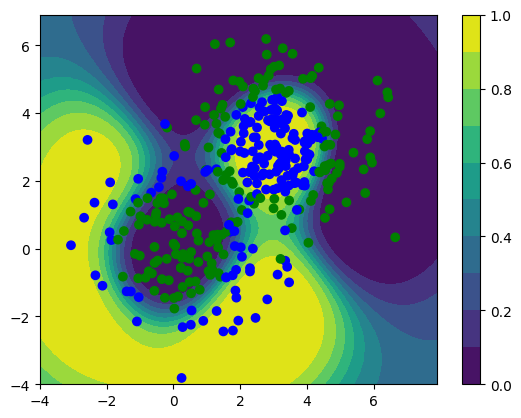

In [71]:
plot_probabilities(svm_class, X_train, y_train, colors)

This underfits slightly with default parameters. Try raising C.

## Poly

This is the second-most used kernel. It is faster than RBF, but less flexible. It's sort of a compromise between linear and RBF.

### Moons

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, random_state=504)
svm_class = SVC(probability=True, decision_function_shape='ovr', kernel='poly', random_state=504)
svm_class.fit(X_train, y_train)

svm_class.score(X_train, y_train), svm_class.score(X_test, y_test)

(0.8933333333333333, 0.92)

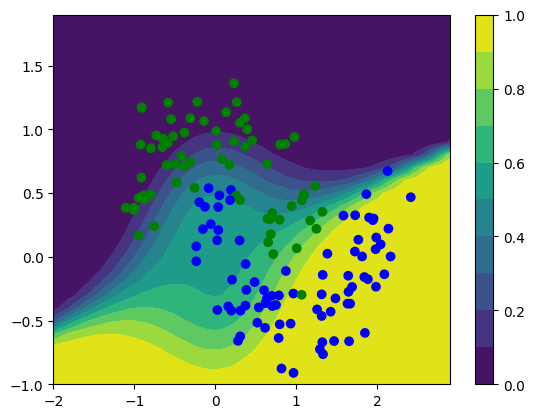

In [37]:
plot_probabilities(svm_class, X_train, y_train, colors)

This underfits because we're using the simple $x^3$ function. We need a more complex shape, so try fiddling with degree and coef0.

### Circles

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_circles, y_circles, random_state=504)
svm_class = SVC(probability=True, decision_function_shape='ovr', kernel='poly', random_state=504)
svm_class.fit(X_train, y_train)

svm_class.score(X_train, y_train), svm_class.score(X_test, y_test)

(0.6755555555555556, 0.5866666666666667)

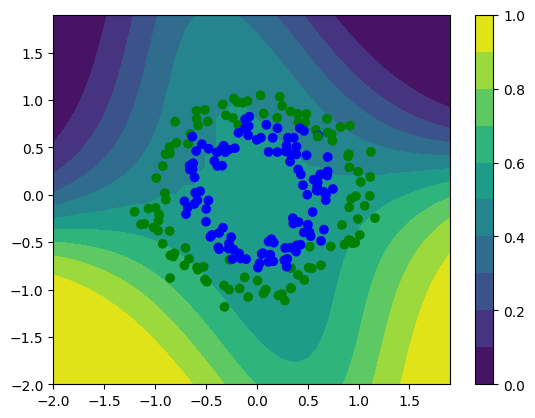

In [39]:
plot_probabilities(svm_class, X_train, y_train, colors)

Intuitively $x^3$ is the wrong degree. What is the right one?

### Gaussian quantiles

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_quan, y_quan, random_state=504)
svm_class = SVC(probability=True, decision_function_shape='ovr', kernel='poly', random_state=504)
svm_class.fit(X_train, y_train)

svm_class.score(X_train, y_train), svm_class.score(X_test, y_test)

(0.6346666666666667, 0.632)

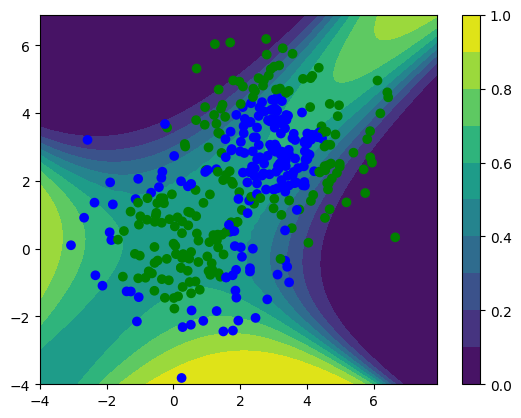

In [41]:
plot_probabilities(svm_class, X_train, y_train, colors)

Here, you need to fiddle with several hyperparamters.